# Velocity concentration correlation

While this correlation would be a key advancement of active matter science and an important aspect of my paper, it's not yet revealed by my analysis. Today, by watching the PIV overlaid videos again and again, I have two observations:
- high concentration regions (dark regions) usually have small velocity at center
- high concentration regions (dark regions) are usually a center of a swirl (similar to the first observation)
- high concentration regions form from "collisions" between two streams (large negative divergence)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage import io
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
import corrLib
from myImageLib import bpass
from miscLib import label_slope
from myImageLib import bestcolor
from scipy.signal import correlate2d

## 1. dark regions have small velocity at center

To test this hypothesis, we compare the filtered <del>(gaussian with sigma as correlation length)</del> image with the velocity magnitude field.

- Velocity magnitude correlation

Velocity magnitude correlation length is 14.38 um.


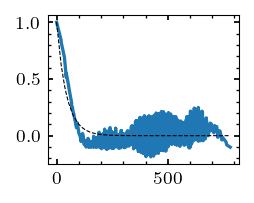

In [7]:
img_folder = r'E:\moreData\08052020\00\8-bit'
piv_folder = r'E:\moreData\08052020\piv_imseq\00'

mpp = 0.33 # um/px
pivData = pd.read_csv(os.path.join(piv_folder, '1882-1883.csv.'))
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
v_2d = {}
for kw in pivData:
    v_2d[kw] = np.array(pivData[kw]).reshape(row, col)
vmag = (v_2d['u'] ** 2 + v_2d['v'] ** 2) ** 0.5
x, y, corrv = corrLib.corrI(v_2d['x'], v_2d['y'], vmag)
corr_r = corrLib.distance_corr(x, y, corrv)
corr_r.R = corr_r.R - corr_r.R.iat[0]
cl, fit = corr_length(corr_r, fitting_range=None)
plt.plot(corr_r.R, corr_r.C)
plt.plot(corr_r.R, exp(corr_r.R, fit[0][0]), color='k', ls='--', lw=0.5)
print('Velocity magnitude correlation length is {:.02f} um.'.format(cl*mpp))

- Velocity correlation

Velocity correlation length is 24.33 um.


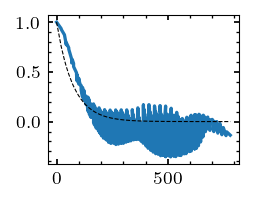

In [8]:
X, Y, CA, CV = corrLib.corrS(v_2d['x'], v_2d['y'], v_2d['u'], v_2d['v'])

corr_rV = corrLib.distance_corr(X, Y, CV)
corr_rV.R = corr_rV.R - corr_rV.R.iat[0]
clV, fitV = corr_length(corr_rV, fitting_range=500)

plt.plot(corr_rV.R, corr_rV.C)
plt.plot(corr_rV.R, exp(corr_rV.R, fitV[0][0]), color='k', ls='--', lw=0.5)
print('Velocity correlation length is {:.02f} um.'.format(clV*mpp))

- Pixel intensity correlation

#### Comments

I just notice that bpass can significantly modify the pixel intensity correlation lengths I measured. **As I increase the lower frequency bound from 1 to 5 (Hz), the correlation length decreases from 28.07 um to 8.64 um!** A natural question is: what's the proper choice of a bpass lower bound? Or is bpass really need in this analysis? Yes we need bpass because when there is a large spatial illumination inhomogeneity, the correlation function does not look like an exponential decay at all. Then how to choose a bpass lower bound? The idea is that we just want to remove the long range illumination inhomogeneity, but keep all other patterns in the image as much as possible. Let's look at a specific case.

Say we the following raw image:
<img src='temp_data\illumination_correction\raw.jpg'>

Do bpass with low frequency bound 0.5, 1, 1.5, 2, 2.5 and 3, we get the following processed images:

|0.5|1|1.5|2|2.5|3|
|:-:|:-:|:-:|:-:|:-:|:-:|
|<img src='temp_data\illumination_correction\bp_0.5.jpg'>|<img src='temp_data\illumination_correction\bp_1.0.jpg'>|<img src='temp_data\illumination_correction\bp_1.5.jpg'>|<img src='temp_data\illumination_correction\bp_2.0.jpg'>|<img src='temp_data\illumination_correction\bp_2.5.jpg'>|<img src='temp_data\illumination_correction\bp_3.0.jpg'>

Compute the correlation length for each of the images above, we get the relation below:

<img src='temp_data\illumination_correction\cl_lb_relation.jpg'>

The correlation length keeps going down when increasing bpass lower bound. From the image where lb=3, we see that the correlation length is dominated by bpass. As a result, bpass is not a feasible method in illumination correction in this case, since the correlation length is very sensitive to the intrinsic low frequency variation in the image, which can be altered by bpass. Therefore, we turn to a different illumination correction technique: **background subtraction**.


## Background subtraction

Method we use here is "correction from a bright image" according to [The Pantheon project](https://clouard.users.greyc.fr/Pantheon/experiments/illumination-correction/index-en.html). The idea is we average several images (to get rid of details from bacteria and particles, and retain the long range illumination inhomogeneity) to get b(x, y). Use the following transformation to correct the image:
$$ g(x, y) = C\frac{f(x, y)}{b(x, y)} $$
where $f(x, y)$ is the input image and $g(x, y)$ is the corrected image. C is defined as:
$$ C = mean(f(x, y))\frac{1}{mean(\frac{f}{b})} $$

In [26]:
nums = range(1000, 2000)
imgs = {}
for n in nums:
    imgs[str(n)] = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))

In [27]:
# take average to get b(x, y)
for num, kw in enumerate(imgs):
    if num == 0:
        avg = imgs[kw].astype('float64')
    else:
        avg += imgs[kw]
#         print(avg[0, 0])
avg = avg / len(imgs)

In [28]:
# correct images
corrected_imgs = {}
for kw in imgs:
    corrected_imgs[kw] = (imgs[kw] / avg * imgs[kw].mean() / (imgs[kw] / avg).mean()).astype('uint8')    

Text(0.5, 1.0, 'corrected')

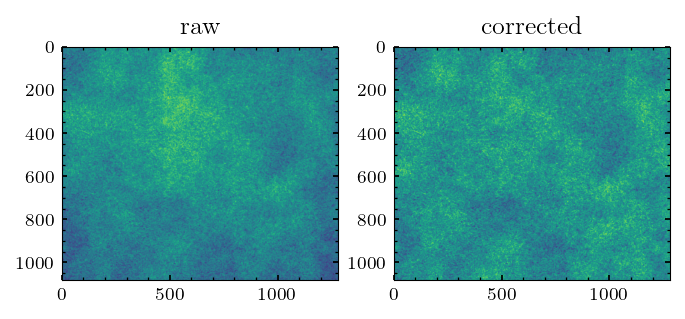

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
ax[0].imshow(imgs['1841'])
ax[0].set_title('raw')
ax[1].imshow(corrected_imgs['1841'])
ax[1].set_title('corrected')

Pixel intensity correlation length is 25.52 um


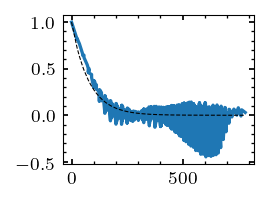

In [188]:
img = corrected_imgs['1700']
X, Y, I = corrLib.divide_windows(img, windowsize=[25, 25], step=25)
XI, YI, CI = corrLib.corrI(X, Y, I)
corr_rI= corrLib.distance_corr(XI, YI, CI)
corr_rI.R = corr_rI.R - corr_rI.R.iat[0]
clI, fitI = corr_length(corr_rI)
print('Pixel intensity correlation length is {:.02f} um'.format(clI*mpp))
plt.plot(corr_rI.R, corr_rI.C)
plt.plot(corr_rI.R, exp(corr_rI.R, fitI[0][0]), color='k', ls='--', lw=0.5)

In [33]:
image_numbers = range(1000, 2000, 20)
clIL = []
clVL = []
for n in image_numbers:
    img = corrected_imgs['{:04d}'.format(n)]
    X, Y, I = corrLib.divide_windows(img, windowsize=[25, 25], step=25)
    XI, YI, CI = corrLib.corrI(X, Y, I)
    corr_rI= corrLib.distance_corr(XI, YI, CI)
    corr_rI.R = corr_rI.R - corr_rI.R.iat[0]
    clI, fitI = corr_length(corr_rI)
    clIL.append(clI)
    
    pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv.'.format(n, n+1)))
    for kw in pivData:
        v_2d[kw] = np.array(pivData[kw]).reshape(row, col)
    X, Y, CA, CV = corrLib.corrS(v_2d['x'], v_2d['y'], v_2d['u'], v_2d['v'])
    corr_rV = corrLib.distance_corr(X, Y, CV)
    corr_rV.R = corr_rV.R - corr_rV.R.iat[0]
    clV, fitV = corr_length(corr_rV, fitting_range=500)
    clVL.append(clV)

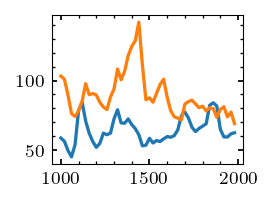

In [34]:
plt.plot(image_numbers, clIL)
plt.plot(image_numbers, clVL)

**Comments:** by averaging 1000 frames, we obtain a reasonably good background subtraction on the images. Correlation length analysis shows that the correlation length of the corrected image is 25.52 um. Remember that the correlation length of velocity is 24.33 um, very close to 25.52 um.

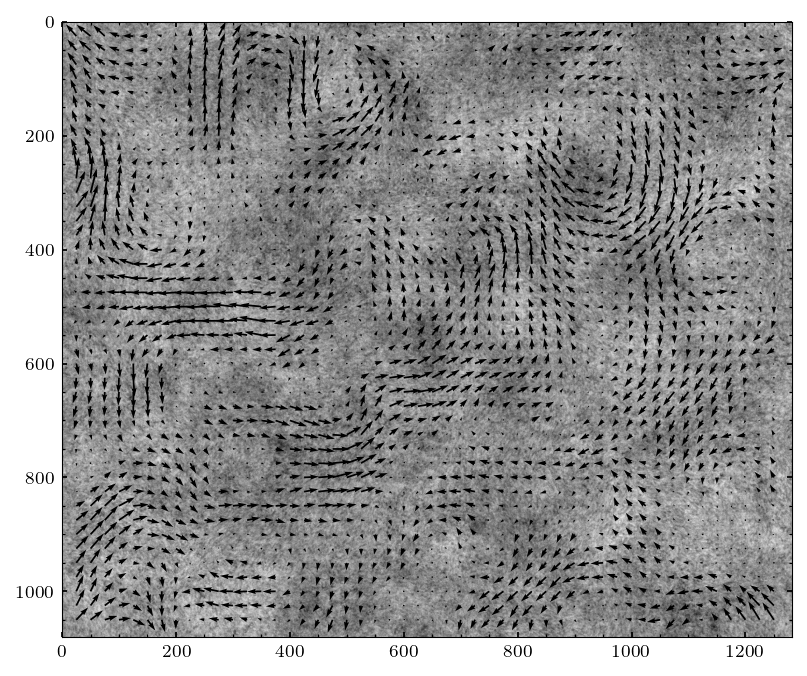

In [4]:
# take 3000.tif in 0803/02 to re-examine the velocity concentration relation
pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\00\1700-1701.csv')
img = io.imread(r'E:\moreData\08032020\00\8-bit\1700.tif')
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

In [218]:
c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, 50, 25)

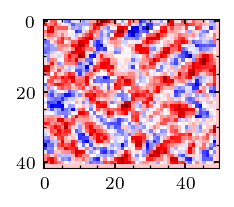

In [223]:
plt.imshow(divv, cmap='seismic')

In [23]:
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)

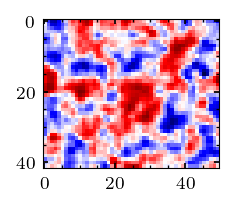

In [222]:
plt.imshow(I, cmap='seismic')

In [224]:
pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\02\3000-3001.csv')
img = io.imread(r'D:\density_fluctuations\08032020\02\8-bit\3000.tif')
c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, 50, 25)
xcn = corr2d(c, divcn)
xcv = corr2d(c, divcv)
xv = corr2d(c, divv)
print('c x divcv: {0:.2f}\nc x divcn: {1:.2f}\nc x divv: {2:.2f}'.format(xcv, xcn, xv))

c x divcv: -0.06
c x divcn: -0.05
c x divv: -0.06


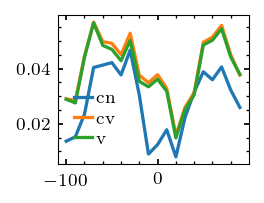

In [100]:
# keep piv, use different img.  c(t+tau) x divv(t)
piv_num = 2500
img_nums = range(piv_num-100, piv_num+100, 10) # 6.7 s
xcnL = []
xcvL = []
xvL = []
for n in img_nums:
    tau = n - piv_num
    img = io.imread(r'D:\density_fluctuations\08032020\04\8-bit\{:04d}.tif'.format(n))
    pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\04\{0:04d}-{1:04d}.csv'.format(piv_num, piv_num+1))
    c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, 50, 25)
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    xcn = corr2d(c, divcn)
    xcv = corr2d(c, divcv)
    xv = corr2d(c, divv)
    xcnL.append(xcn)
    xcvL.append(xcv)
    xvL.append(xv)
tauL = np.array(img_nums) - piv_num
plt.plot(tauL, xcnL, label='cn')
plt.plot(tauL, xcvL, label='cv')
plt.plot(tauL, xvL, label='v')
plt.legend()

In [153]:
n = 2500
I0 = io.imread(r'D:\density_fluctuations\08032020\01\8-bit\{:04d}.tif'.format(n))
I1 = io.imread(r'D:\density_fluctuations\08032020\01\8-bit\{:04d}.tif'.format(n+30))
pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\01\{0:04d}-{1:04d}.csv'.format(n, n+1))
c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, 50, 25)
X, Y, dc = corrLib.divide_windows(I0-I1, windowsize=[50, 50], step=25)
dcxdivv = corr2d(dc, divv)
print('dc x divv: {:.2f}'.format(dcxdivv))

dc x divv: 0.13


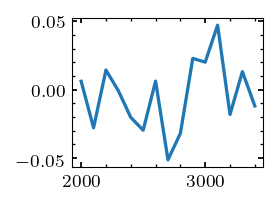

In [166]:
corr = []
nL = range(2000, 3500, 100)
for n in nL:
    I0 = io.imread(r'D:\density_fluctuations\08032020\09\8-bit\{:04d}.tif'.format(n))
    I1 = io.imread(r'D:\density_fluctuations\08032020\09\8-bit\{:04d}.tif'.format(n+60))
    pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\09\{0:04d}-{1:04d}.csv'.format(n, n+1))
    c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, 50, 25)
    X, Y, dc = corrLib.divide_windows(I0-I1, windowsize=[50, 50], step=25)
    dcxdivv = corr2d(dc, divv)
    corr.append(dcxdivv)
plt.plot(nL, corr)

In [206]:
def data_log():
    log = {}
    log['08032020'] = {}
    log['08032020']['num'] = list(range(0, 15))
    log['08032020']['fps'] = [30, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 10, 10, 10, 10]
    log['08042020'] = {}
    log['08042020']['num'] = list(range(0, 12))
    log['08042020']['fps'] = [30, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10]
    log['08052020'] = {}
    log['08052020']['num'] = list(range(0, 12))
    log['08052020']['fps'] = [30, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10]
    log['08062020'] = {}
    log['08062020']['num'] = list(range(0, 13))
    log['08062020']['fps'] = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 10]
    return log

Text(0, 0.5, 'Correlation')

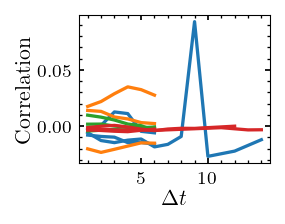

In [18]:
# visualize dcxdivv data with various dt
date = '08032020'
num = data_log()[date]['num']
fps = data_log()[date]['fps']
for n, f in zip(num[0:12], fps[0:12]):
    data = pd.read_csv(r'E:\moreData\{0}\div_x_dcadv\{1:02d}\divvXdcadv.csv'.format(date, n)).sort_values(by=['dt'])
    plt.plot(data['dt']/f, data['dc_divv'], color=bestcolor(n//3))
plt.xlabel('$\Delta t$')
plt.ylabel('Correlation')

**Comment:** The correlation between divergence of velocity and concentration field looks random. Let's explore more ways of calculating divergence.

In [225]:
pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\02\3000-3001.csv')
img = io.imread(r'D:\density_fluctuations\08032020\02\8-bit\3000.tif')

In [237]:
xfilt = np.array([[-0.707, 0, 0.707],
                  [-1,     0, 1],
                  [-0.707, 0, 0.707]])
yfilt = np.array([[-0.707, -1, -0.707],
                  [0,     0, 0],
                  [0.707, 1, 0.707]])
# xfilt = xfilt / xfilt.sum()
# yfilt = yfilt / xfilt.sum()

In [232]:

X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
u = np.array(pivData.u).reshape(I.shape)
v = np.array(pivData.v).reshape(I.shape)

In [238]:
corrx = correlate2d(u, xfilt, mode='same')
corry = correlate2d(v, yfilt, mode='same')

In [239]:
corr = corrx + corry

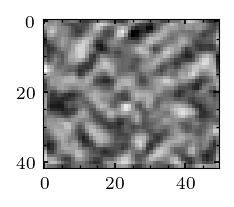

In [240]:
plt.imshow(corr, cmap='gray')

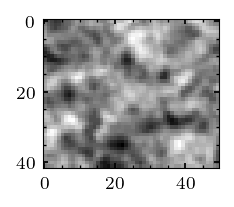

In [241]:
plt.imshow(I, cmap='gray')

In [244]:
corr2d(corr, divv)

0.8611740397714692

**Comments:** New way of calculating divergence field gives similar results. The div field obtained from different methods has correlation 0.86!